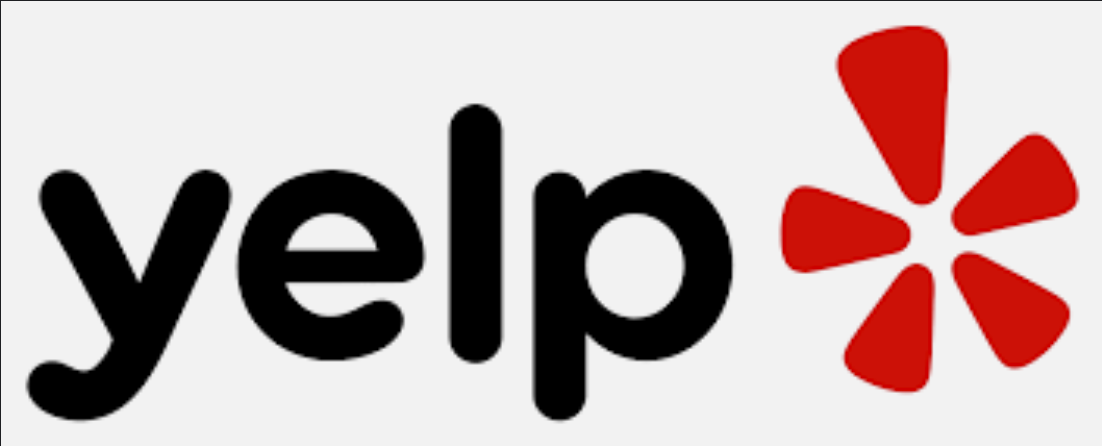

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
                                                            
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/yelp_review.csv")

In [ ]:
data=df.sample(n=20000)
data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
4321345,X-gAL8XafAlBspyD7Llmsg,waLzCWwLmFkfHiaKiTjomg,QvSWiMx0vT09mfO0TxJy_w,1,2015-02-27,I used to be a regular customer at this restau...,2,0,0
1832959,n190ynsFabvllhZWu5Iukw,UEiLmfklwIfjNcEvBwHN0A,CaF9FC8GEBfDDbptPgkgBw,1,2017-07-24,"Well to start off, I was there the other night...",0,0,0
3840558,Swl1mDU2ZgF5P0GLxUiiSQ,ZFeSFlfrQASkdojcxrZWBA,-HgbBv9Yjqv735F9fwCZNg,3,2014-04-14,Red tavern burger and bottomless fries with a ...,0,0,0
4483865,5cQwagra-y1eSJAj-JWEww,JGGdzfzTOqv2l--aAT4Qcw,IWf4-jLcIUxSNbVKcU_-xw,4,2012-07-17,I agree with Rachel C. -- the staff IS super n...,0,0,0
3558799,qliN1hgNtFqiVaZqQp14Og,68Qe6He6OH50viYCFm37jQ,K-uQkfSUTwu5LIwPB4b_vg,5,2014-12-13,Go. Hurry and go. Mexican food with such an am...,3,0,2


In [ ]:
data.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import  LSTM
from keras.layers import Conv1D, MaxPooling1D
import re


In [ ]:
# We need to get rid of special marks from reviews
def  clean_text(text):
    
    text = text.str.lower()
    text = text.apply(lambda T: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", T))  
        
    return text

In [ ]:
data['text']= clean_text(data['text'])

In [ ]:
data['text'] = data['text'].str.replace('#','')

In [ ]:
data.text.head()

4321345    i used to be a regular customer at this restau...
1832959    well to start off i was there the other night ...
3840558    red tavern burger and bottomless fries with a ...
4483865    i agree with rachel c  the staff is super nice...
3558799    go hurry and go mexican food with such an amaz...
Name: text, dtype: object

In [ ]:
data["stars"].value_counts()

5    8679
4    4628
1    2714
3    2390
2    1589
Name: stars, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
rev=data["text"]
target=data["stars"]
x_train, x_test, y_train, y_test = train_test_split(rev,target,test_size=0.1,random_state=0,stratify=target)

If the test size id 0.1, we are using 90% of the data to build the training subset and 10% of the data is used to build the validation subset. In the same way, when we use 0.2, then 20% of the data are used to build the validation set. Same as 0.3. To get the smallest mape error, we choose to use 0.1 for the models.

In [ ]:
average_star=y_test.mean()
mae=0
for stars in y_test:
    mae+=abs(stars-average_star)
print(mae/len(y_test))

1.2020810000000017


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 200
batch_size = 32

#Tokenizing
tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# X_train with upper case "X" is tokenized, x_train with lower case "x" is not

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
X_train_df = pd.DataFrame(X_train)
X_train_df

18000 train sequences
2000 test sequences
Pad sequences (samples x text length)
X_train shape: (18000, 200)
X_test shape: (2000, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,4149,2313,3,1,11,5,310,2,300,33,289,774,10,127,1264,316,72,3865,11,2,310,2,852,28,5,177,769,3,9,3159,55
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,25,344,65,32,2,2799,10,38,1,2,296,153,352,411,151,3,2,29,10,72,331,283,2,397,38,209,6,31,1276,33,87,33,2,576,1711,2,2728,28,32
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,359,75,264,54,18,254,23,5,32,128,6,49,75,6,110,8450,72,472,4,284,9,136,243,7,77,2,30,7,121,32,5,108,551,11,2,3960,591,202,847
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,20,6,1141,68,318,53,405,3,20,52,22,6,60,6,2,301,3,324,84,20,171,112,38,16,29,10,201,3,4,61,114,94,57,117,15,13,249,3,282
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,205,6,162,1,5,105,9,88,5,32,1998,19,65,1265,3,2,370,10,787,33,1,370,10,140,2,85,8,2,297,111,1,3,129,99,5,181,8,443,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2810,344,3,71,470,359,13,480,1297,28,124,238,4,239,780,6,178,246,3,822,2182,118,333,63,1087,6,1341,13,517,35,502,35,1678,307,2725,10,126,306,143,107
17996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13,282,4,22,101,254,76,15,465,144,16,10,5,36,109,29,6,467,68,1960,4,1184,76,1,402,10,1791,3,260,16,10,2,72,29,4,71,22,3811,8,608
17997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,440,9,7,5,3948,6,732,107,60,2,4173,26,32,11,38,3854,178,250,6738,259,1,1699,24,9488,3,734,16,10,2,278,29,11,68,436,6,878,7185,207,207,207
17998,178,1787,9,88,1597,56,1,394,8,1114,1787,3615,4,642,57,12,8726,54,16,315,104,55,11,1413,21,1,18,22,67,838,9,462,84,2575,53,1787,352,178,418,3,...,1,172,8,1427,46,64,88,67,1,5,1,112,2,194,150,232,9,9415,2,4661,1043,15,2,5098,6098,12,2,2945,16,10,216,5,275,515,6,38,8,20,1231,2531


## LSTM

In [ ]:
  model = Sequential()
  model.add(Embedding(max_features, 64, input_length=maxlen))
  model.add(LSTM(32,return_sequences=True,dropout=0.1,recurrent_dropout=0.1))
  model.add(LSTM(16))
  model.add(Dense(1))

  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 200, 32)           12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 655,569
Trainable params: 655,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    steps_per_epoch = 128,
                    epochs=25,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))


print("The testing accuracy is :",model.evaluate(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/25
128/128 [==============================] - 50s 345ms/step - loss: 1.3934 - mape: 62.4742 - val_loss: 1.1241 - val_mape: 61.1108
Epoch 2/25
128/128 [==============================] - 43s 338ms/step - loss: 1.0611 - mape: 56.3578 - val_loss: 0.9562 - val_mape: 53.8908
Epoch 3/25
128/128 [==============================] - 43s 339ms/step - loss: 0.8352 - mape: 41.0346 - val_loss: 0.7050 - val_mape: 34.1857
Epoch 4/25
128/128 [==============================] - 43s 338ms/step - loss: 0.7261 - mape: 32.7624 - val_loss: 0.6561 - val_mape: 30.8803
Epoch 5/25
128/128 [==============================] - 43s 337ms/step - loss: 0.6348 - mape: 27.8902 - val_loss: 0.5861 - val_mape: 24.6841
Epoch 6/25
128/128 [==============================] - 43s 338ms/step - loss: 0.5983 - mape: 25.1344 - val_loss: 0.6110 - val_mape: 24.0229
Epoch 7/25
128/128 [==============================] - 43s 339ms/step - loss: 0.5781 - mape: 24.4151 - val_loss: 0.5720 - val_mape: 24.9762
Epoch 8/25
128/128 [=======

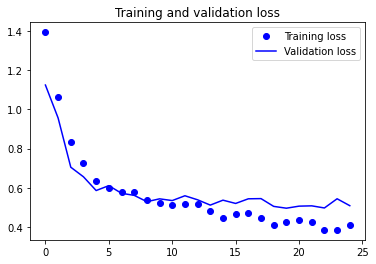

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Simple RNN

In [ ]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs

model.add(Embedding(max_features, 64, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 64)`.

model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(16, return_sequences=True))
model.add(SimpleRNN(32)) # default activation is "tanh"
model.add(Dense(1))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 32)           3104      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200, 16)           784       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 645,489
Trainable params: 645,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    steps_per_epoch = 128,
                    epochs=25,
                    batch_size= batch_size,
                    validation_data=(X_test,y_test))
print("The testing mape is :",model.evaluate(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/25
128/128 [==============================] - 25s 169ms/step - loss: 1.3493 - mape: 65.5451 - val_loss: 1.1316 - val_mape: 60.8740
Epoch 2/25
128/128 [==============================] - 19s 145ms/step - loss: 1.1215 - mape: 61.4268 - val_loss: 1.1365 - val_mape: 64.1861
Epoch 3/25
128/128 [==============================] - 19s 146ms/step - loss: 1.1207 - mape: 61.5947 - val_loss: 1.1173 - val_mape: 61.4318
Epoch 4/25
128/128 [==============================] - 18s 145ms/step - loss: 1.1055 - mape: 60.9900 - val_loss: 1.1150 - val_mape: 61.9293
Epoch 5/25
128/128 [==============================] - 19s 145ms/step - loss: 1.0250 - mape: 55.7344 - val_loss: 1.0460 - val_mape: 58.1098
Epoch 6/25
128/128 [==============================] - 19s 150ms/step - loss: 0.8413 - mape: 43.1040 - val_loss: 0.8963 - val_mape: 44.3662
Epoch 7/25
128/128 [==============================] - 19s 147ms/step - loss: 0.7762 - mape: 36.5504 - val_loss: 0.7881 - val_mape: 36.9864
Epoch 8/25
128/128 [=======

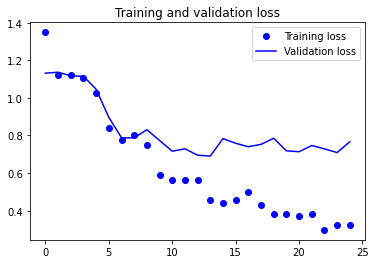

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## CONV1D & LSTM

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=maxlen))
model.add(Conv1D(64,10,activation="relu"))
model.add(MaxPooling1D(3))
model.add(LSTM(32,return_sequences=True,dropout=0.1,recurrent_dropout=0.1))
model.add(LSTM(16))
model.add(Dense(1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 191, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 63, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                        

In [ ]:
model.compile(optimizer='rmsprop', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    steps_per_epoch = 128,
                    epochs=25,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))


keras.backend.clear_session()
del model

Epoch 1/25
128/128 [==============================] - 27s 173ms/step - loss: 1.1369 - mape: 53.1573 - val_loss: 0.8205 - val_mape: 39.2743
Epoch 2/25
128/128 [==============================] - 21s 166ms/step - loss: 0.7811 - mape: 37.7082 - val_loss: 0.7224 - val_mape: 35.2606
Epoch 3/25
128/128 [==============================] - 21s 166ms/step - loss: 0.7134 - mape: 32.1917 - val_loss: 0.6437 - val_mape: 26.7374
Epoch 4/25
128/128 [==============================] - 21s 165ms/step - loss: 0.6755 - mape: 29.0378 - val_loss: 0.6793 - val_mape: 23.7431
Epoch 5/25
128/128 [==============================] - 23s 176ms/step - loss: 0.6176 - mape: 25.9234 - val_loss: 0.6260 - val_mape: 21.9542
Epoch 6/25
128/128 [==============================] - 21s 165ms/step - loss: 0.5853 - mape: 24.4246 - val_loss: 0.6127 - val_mape: 21.9979
Epoch 7/25
128/128 [==============================] - 21s 165ms/step - loss: 0.5658 - mape: 23.2769 - val_loss: 0.5948 - val_mape: 26.8929
Epoch 8/25
128/128 [=======

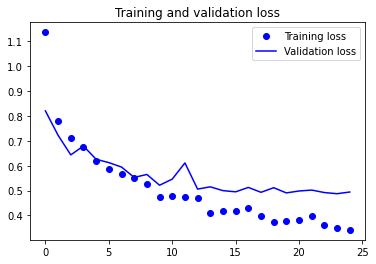

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()